In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('./data/ACME-HappinessSurvey2020.csv')
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


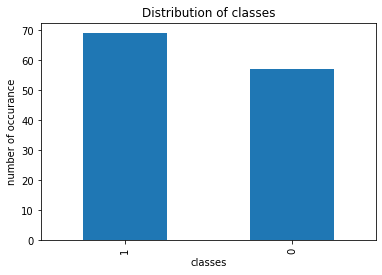

In [4]:
df['Y'].value_counts().plot(kind='bar', xlabel='classes', ylabel='number of occurance',
                            title='Distribution of classes')
plt.show()

The data appear to be clean and the classes are balanced. So there should be no additional cleaning and upsampling/downsampling required.

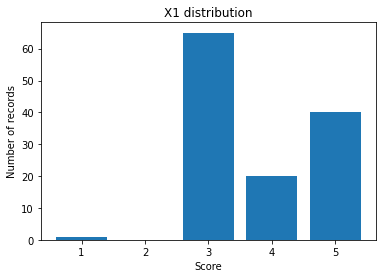

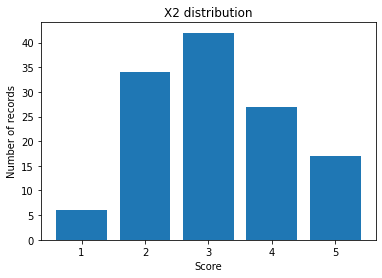

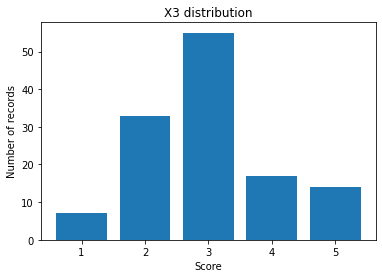

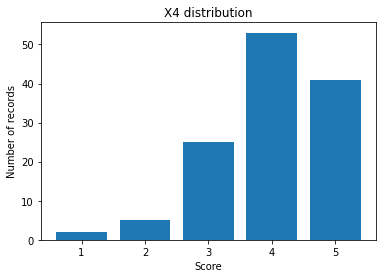

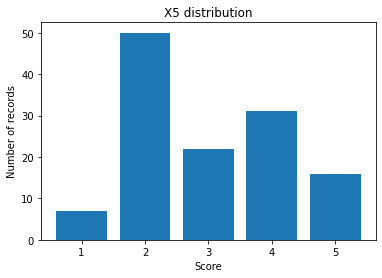

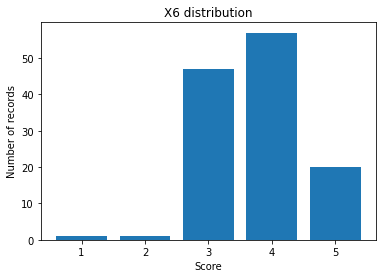

In [6]:
X = df.drop('Y', axis=1)
y = df['Y']

for column in X.columns:
    plt.figure()
    plt.bar(X[column].unique(), X[column].value_counts())
    plt.title(f'{column} distribution')
    plt.xlabel('Score')
    plt.ylabel('Number of records')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [8]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print(f'Training Accuracy:{logreg.score(X_train, y_train)}')
print(f'Testing Accuracy:{logreg.score(X_test, y_test)}')

Training Accuracy:0.55
Testing Accuracy:0.6923076923076923


With a simple logistic regression model, we get 55% training accuracy and 69% testing accuracy, indicating underfitting of the data. We can either increment the size of the data set which would not be feasible in this case or instead use a more complex model like random forest classifier to tackle the issue.

In [11]:
rf = RandomForestClassifier(random_state=22)
rf.fit(X_train, y_train)
print(f'Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Testing Accuracy: {rf.score(X_test, y_test)}')

Training Accuracy: 0.94
Testing Accuracy: 0.6538461538461539


The Training accuracy drastically improves with RandomForestClassifier. However, the model seems to be overfitting the training data as it is 30% higher than the testing accuracy. We could tune the hyperparameters to reduce overfitting.

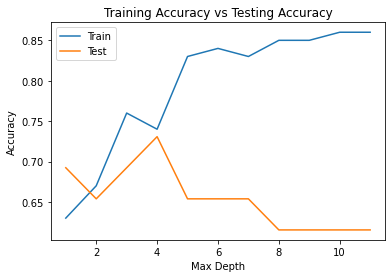

In [24]:
depths = np.arange(1,12)
train_accs = []
test_accs = []

for depth in depths:
    rf = RandomForestClassifier(n_estimators=50, max_depth=depth, min_samples_leaf=2,
                                random_state=22)
    rf.fit(X_train, y_train)
    train_accs.append(rf.score(X_train, y_train))
    test_accs.append(rf.score(X_test, y_test))
    
plt.figure()
plt.plot(depths, train_accs, label='Train')
plt.plot(depths, test_accs, label='Test')
plt.title('Training Accuracy vs Testing Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It seems that the model exhibits the best performance with max_depth set to 4, so that will be the parameter we choose.

In [26]:
rf = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=2,
                        random_state=22)
rf.fit(X_train, y_train)
print(f'Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Testing Accuracy: {rf.score(X_test, y_test)}')

Training Accuracy: 0.74
Testing Accuracy: 0.7307692307692307


We can now move on the analyzing the importance of the features.

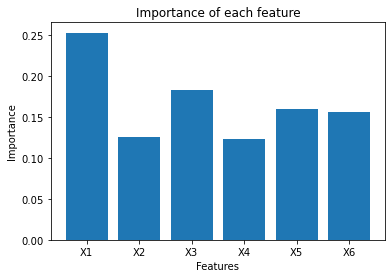

In [33]:
plt.figure()
plt.bar(X.columns, rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Importance of each feature')
plt.show()

The two features with lowest importance are `X2` and `X4`. We can try removing them from the training and see how does the performance change.

In [39]:
X_4_feature = X.drop(['X2', 'X4'], axis=1)
X_train_4_feature, X_test_4_feature, y_train, y_test = train_test_split(X_4_feature,
                                                y, test_size=0.2, random_state=40)

rf_4_feature = RandomForestClassifier(n_estimators=50, max_depth=4, min_samples_leaf=2,
                        random_state=22)
rf_4_feature.fit(X_train_4_feature, y_train)
print(f'Training Accuracy: {rf_4_feature.score(X_train_4_feature, y_train)}')
print(f'Testing Accuracy: {rf_4_feature.score(X_test_4_feature, y_test)}')

Training Accuracy: 0.82
Testing Accuracy: 0.5769230769230769


After dropping off the least important features, the model starts to overfit the training data again and the performance on the testset drops significantly. However, what if we switch back to the simple logistic regression model?

In [37]:
logreg_4_feature = LogisticRegression()
logreg_4_feature.fit(X_train_4_feature, y_train)
print(f'Training Accuracy:{logreg_4_feature.score(X_train_4_feature, y_train)}')
print(f'Testing Accuracy:{logreg_4_feature.score(X_test_4_feature, y_test)}')

Training Accuracy:0.58
Testing Accuracy:0.6538461538461539


We can see that despite the model is still underfitting, dropping the two least important features actually improved the training accuracy without compromising the testing accuracy at all. This might indicate that we can still find a model that is complex enough to still maintain the same level of performance even with less features without over fitting the training set.

In [103]:
rf_4_feature = RandomForestClassifier(n_estimators=55, max_depth=2, min_samples_leaf=3,
                        random_state=22)
rf_4_feature.fit(X_train_4_feature, y_train)
print(f'Training Accuracy: {rf_4_feature.score(X_train_4_feature, y_train)}')
print(f'Testing Accuracy: {rf_4_feature.score(X_test_4_feature, y_test)}')

Training Accuracy: 0.67
Testing Accuracy: 0.6923076923076923


It seems that we could potentially remove `X2` and `X4` in the next survey. Which makes sense since customer are most likely to have purchased the product acknowledging what is to expect and the price of the item.